## Composite plot for wind variables-Samuel Ekwacu 

In [8]:
# Import existing code modules
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#from matplotlib.colors import ListedColormap
#import cmaps
import geocat.viz as gv

In [9]:
#open the files   
ds= xr.open_dataset('C:/Diabatic_data/WIND/uvwind_mon/uvwind1_1961-2021.nc') 
ds.data_vars

Data variables:
    u        (time, lev, lat, lon) float32 ...
    v        (time, lev, lat, lon) float32 ...

In [10]:
#wspd.lev  # print presure level
ds = ds.sel(lev=85000) #selecting to the pressure level
#ds

In [11]:
ds.coords['lon']=(ds.coords['lon']+180)%360-180
ds=ds.sortby(ds.lon) 

In [12]:
#specify the period of interest
ds1= ds.sel(time=slice("1982-01-01", "2000-12-01"))
ds2= ds.sel(time=slice("2001-01-01", "2019-12-01"))

In [13]:
AA=ds1.mean('time') 
BB=ds2.mean('time') 
#BB

In [14]:
#compute for the difference in the variables
diff = AA - BB


In [15]:
#open the siginificance files    
ds3 = xr.open_dataset('C:/Diabatic_data/WIND/uvwind_mon/uwind_pvalue_active_inactive_diff.nc')

In [16]:
ds3.coords['lon']=(ds3.coords['lon']+180)%360-180
ds3=ds3.sortby(ds3.lon)
diff_sig=ds3.sig

In [17]:
# for wind vector plot
d4 = xr.open_dataset('C:/Diabatic_data/WIND/uvwind_mon/JRA55_wind_850hpa_active_inactive_diff.nc')
ds1 = d4.sel(lev=85000) #selecting to the pressure level
#d5.var

In [19]:
ds1.coords['lon']=(ds1.coords['lon']+180)%360-180
d5=ds1.sortby(ds1.lon)
#d5.u.plot()
#d5

In [102]:
#Make an average of the wind variables
wspd_wind = np.mean(np.sqrt(np.add(np.square(d5.u),np.square(d5.v))),axis=0)
u_wind = np.mean(d5.u,axis=0)
v_wind = np.mean(d5.v,axis=0)
#v_wind

In [103]:
#setting up the quiver arguments (these display the wind vectors on the plot)
xx_wind = wspd_wind.lon.values
yy_wind = wspd_wind.lat.values
X_wind,Y_wind =np.meshgrid(xx_wind, yy_wind)
U_wind = u_wind.data
V_wind = v_wind.data

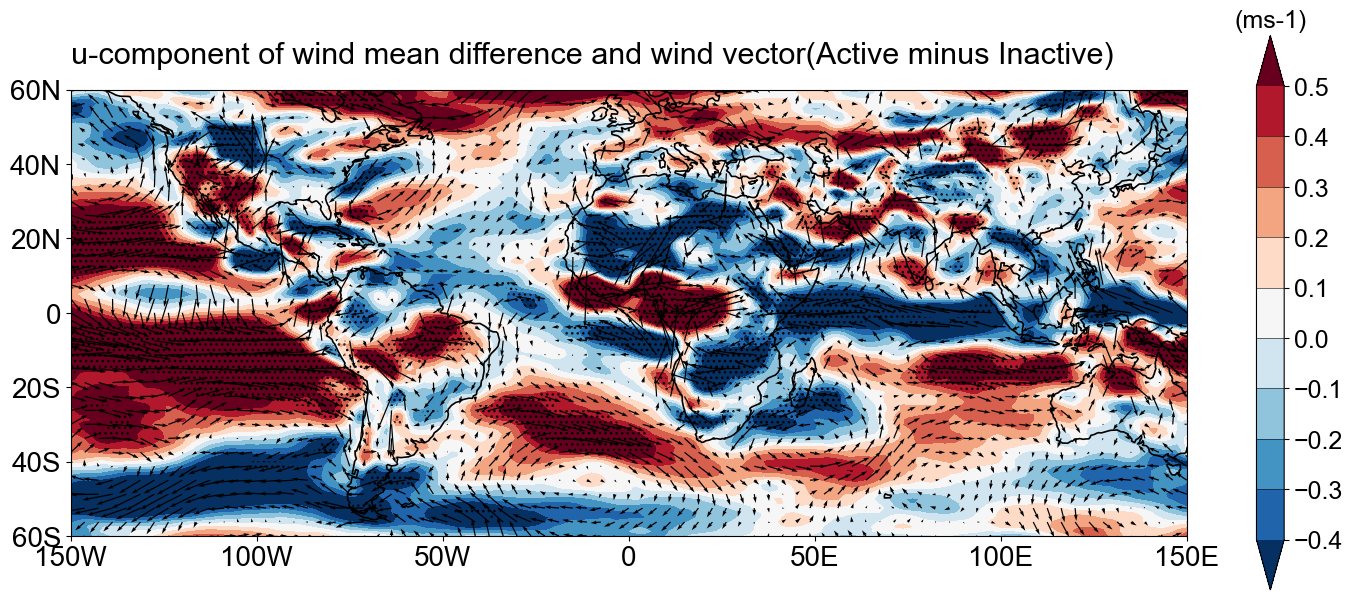

In [104]:
##### plotting
# Create a wider than normal figure to support our many plots
fig = plt.figure(figsize=(18,9))
plt.gcf().subplots_adjust(hspace=0.1, wspace=1)
plt.rcParams["font.family"] = "Arial"



def Plot(row, col, pos, diff, diff_sig, clevs, cbar_label, title):
    # Generate axes, using cartopy, drawing coastlines, and adding features
    projection = ccrs.PlateCarree()#(central_longitude=0)
    ax = fig.add_subplot(row, col, pos, projection=projection)
    #plt.xlim([-50, 100])
    #plt.ylim([-50, 40])
    #plt.gca().set_yticks(np.arange(-50,50,20),crs=ccrs.PlateCarree())
    #plt.gca().set_xticks(np.arange(-50,110,25),crs=ccrs.PlateCarree())
    plt.xlim([-150, 150])
    plt.ylim([-60, 60])
    plt.gca().set_yticks(np.arange(-60,80,20),crs=ccrs.PlateCarree())
    plt.gca().set_xticks(np.arange(-150,170,50),crs=ccrs.PlateCarree())
    lon_formatter=LongitudeFormatter(degree_symbol=''); lat_formatter=LatitudeFormatter(degree_symbol='')
    ax.xaxis.set_major_formatter(lon_formatter); ax.yaxis.set_major_formatter(lat_formatter);ax.tick_params(labelsize=20)
    xticks = ax.xaxis.get_major_ticks(); xticks[2].set_visible(True)
    
   # ax.coastlines(resolution='10m', color='black',linewidth=10)
    #ax.coastlines(resolution='10m', color='black', linewidth=0.7)
    #ax.add_feature(cfeature.BORDERS, linewidth=0.1)
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Contourf-plot data
    temp = diff.u.plot.contourf(ax=ax,
                           transform=ccrs.PlateCarree(),
                           levels=clevs,
                           cmap=plt.cm.RdBu_r,
                           add_colorbar=False,
                           extend='both')
    
    #ax.coastlines(resolution='10m', color='black',linewidth=1)
    ax.coastlines(linewidth=1.2)
   # ax.add_feature(cfeature.BORDERS, linewidth=1)
     # Plot Hatch
    pval = diff_sig
    cond = (pval <= 0.05)
    ## Mask out the areas that do not satisfy the conditions
    sig = pval.where(cond)
    
    ## make a hatch of significance
    plt.contourf(sig.lon,sig.lat,sig,hatches=['...'],alpha=0,
                 transform=ccrs.PlateCarree()) 
    
        # Add color bar
    cbar = plt.colorbar(temp,
                        orientation='vertical',
                        shrink=0.8,
                        extendfrac='auto', 
                        extendrect=False, 
                        drawedges=True)

    cbar.ax.tick_params(labelsize=18)
    cbar.set_ticks(clevs)
    cbar.ax.set_title(cbar_label, size=18)

    # Use geocat.viz.util convenience function to set titles and labels without calling several matplotlib functions
    gv.set_titles_and_labels(ax,
                            maintitle="",
                            lefttitle=title,
                            lefttitlefontsize=22,
                            righttitle="",
                            righttitlefontsize=22,
                            xlabel="",
                            ylabel="")


# define the levels for each variable
#clevs  = [-0.6 ,-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
clevs  = [-0.4 ,-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
Plot(1, 1, 1, diff, diff_sig, clevs, '(ms-1)', "u-component of wind mean difference and wind vector(Active minus Inactive)")

plt.quiver(X_wind[::3, ::3], Y_wind[::3, ::3], U_wind[::3, ::3], V_wind[::3, ::3], 
           transform=ccrs.PlateCarree(), color='k', scale=30, width=0.0011,)
#plt.quiver(X_wind[::3, ::3], Y_wind[::3, ::3], U_wind[::3, ::3], V_wind[::3, ::3], 
#           transform=ccrs.PlateCarree(), color='k', scale=35, width=0.0011,)
fig.savefig('C:/Diabatic_data/WIND/uvwind_mon/JRA55_uwind_Ttest_sig_diff.png', bbox_inches='tight', pad_inches = 0.1, dpi=300)
plt.show()

### For wind speed, Composite plot

In [50]:
#open the files   
wspd= xr.open_dataset('C:/Diabatic_data/WIND/uvwind_mon/wspd_1961-2021.nc') 
wspd.data_vars

Data variables:
    ws       (time, lev, lat, lon) float32 ...

In [51]:
#wspd.lev  # print presure level
ws = wspd.sel(lev=85000) #selecting to the pressure level
#ws

In [52]:
ws.coords['lon']=(ws.coords['lon']+180)%360-180
ws1=ws.sortby(ws.lon) 

In [53]:
#specify the period of interest
df= ws1.sel(time=slice("1982-01-01", "2000-12-01"))
df1= ws1.sel(time=slice("2001-01-01", "2019-12-01"))

In [54]:
df2=df.mean('time') 
df3=df1.mean('time') 
#BB1

In [55]:
#compute for the difference in the variables
diff1 = df2 - df3
#diff1

In [56]:
#open the siginificance files    
wpd = xr.open_dataset('C:/Diabatic_data/WIND/uvwind_mon/wspd_pvalue_active_inactive_diff.nc')
#diff_sig

In [57]:
wpd.coords['lon']=(wpd.coords['lon']+180)%360-180
wpd1=wpd.sortby(wpd.lon)
diff_sig1=wpd1.sig

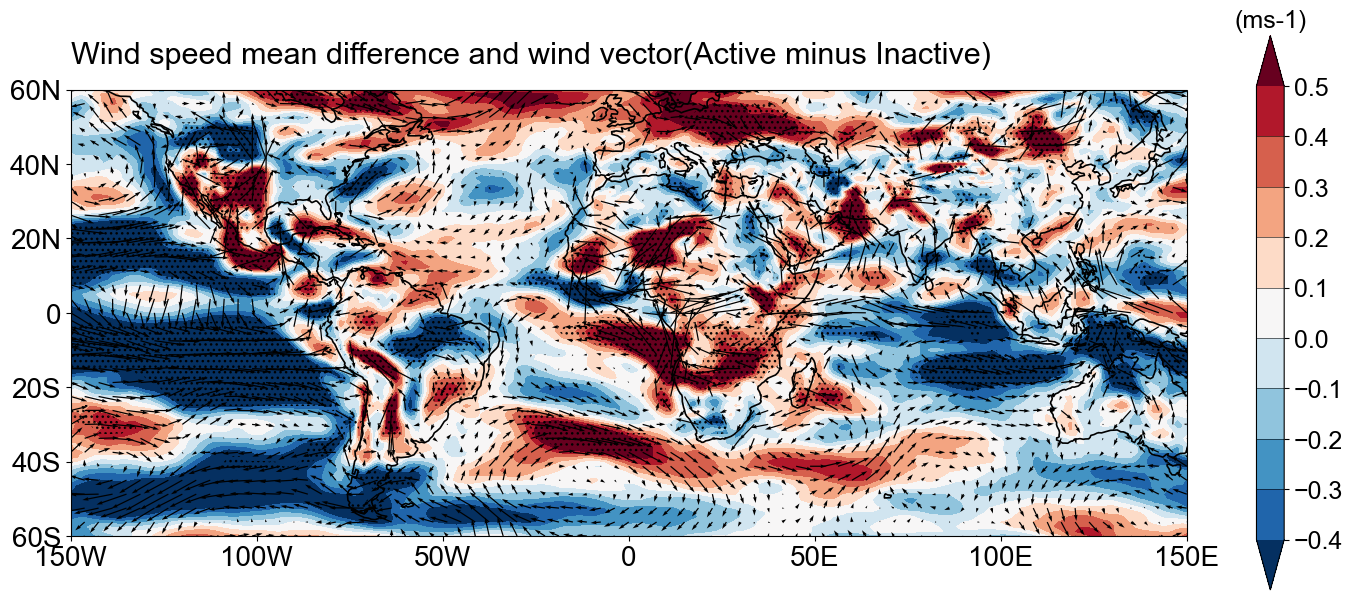

In [74]:
##### plotting
# Create a wider than normal figure to support our many plots
fig = plt.figure(figsize=(18,9))
plt.gcf().subplots_adjust(hspace=0.1, wspace=1)
plt.rcParams["font.family"] = "Arial"



def Plot(row, col, pos, diff, diff_sig, clevs, cbar_label, title):
    # Generate axes, using cartopy, drawing coastlines, and adding features
    projection = ccrs.PlateCarree()#(central_longitude=0)
    ax = fig.add_subplot(row, col, pos, projection=projection)
    plt.xlim([-150, 150])
    plt.ylim([-60, 60])
    plt.gca().set_yticks(np.arange(-60,80,20),crs=ccrs.PlateCarree())
    plt.gca().set_xticks(np.arange(-150,170,50),crs=ccrs.PlateCarree())
   # plt.gca().set_yticks(np.arange(-60,90,30),crs=ccrs.PlateCarree())
   # plt.gca().set_xticks(np.arange(-150,300,50),crs=ccrs.PlateCarree())
    lon_formatter=LongitudeFormatter(degree_symbol=''); lat_formatter=LatitudeFormatter(degree_symbol='')
    ax.xaxis.set_major_formatter(lon_formatter); ax.yaxis.set_major_formatter(lat_formatter);ax.tick_params(labelsize=20)
    xticks = ax.xaxis.get_major_ticks(); xticks[2].set_visible(True)
    
   # ax.coastlines(resolution='10m', color='black',linewidth=10)
    #ax.coastlines(resolution='10m', color='black', linewidth=0.7)
    #ax.add_feature(cfeature.BORDERS, linewidth=0.1)
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Contourf-plot data
    temp = diff1.ws.plot.contourf(ax=ax,
                           transform=ccrs.PlateCarree(),
                           levels=clevs,
                           cmap=plt.cm.RdBu_r,
                           add_colorbar=False,
                           extend='both')
    
    #ax.coastlines(resolution='10m', color='black',linewidth=1)
    ax.coastlines(linewidth=1.2)
   # ax.add_feature(cfeature.BORDERS, linewidth=1)
     # Plot Hatch
    pval = diff_sig1
    cond = (pval <= 0.05)
    ## Mask out the areas that do not satisfy the conditions
    sig = pval.where(cond)
    
    ## make a hatch of significance
    plt.contourf(sig.lon,sig.lat,sig,hatches=['...'],alpha=0,
                 transform=ccrs.PlateCarree()) 
    
        # Add color bar
    cbar = plt.colorbar(temp,
                        orientation='vertical',
                        shrink=0.8,
                        extendfrac='auto', 
                        extendrect=False, 
                        drawedges=True)

    cbar.ax.tick_params(labelsize=18)
    cbar.set_ticks(clevs)
    cbar.ax.set_title(cbar_label, size=18)

    # Use geocat.viz.util convenience function to set titles and labels without calling several matplotlib functions
    gv.set_titles_and_labels(ax,
                            maintitle="",
                            lefttitle=title,
                            lefttitlefontsize=22,
                            righttitle="",
                            righttitlefontsize=22,
                            xlabel="",
                            ylabel="")


# define the levels for each variable
#clevs  = [-0.6 ,-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
clevs  = [-0.4 ,-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
Plot(1, 1, 1, diff, diff_sig1, clevs, '(ms-1)', "Wind speed mean difference and wind vector(Active minus Inactive)")

plt.quiver(X_wind[::3, ::3], Y_wind[::3, ::3], U_wind[::3, ::3], V_wind[::3, ::3], 
           transform=ccrs.PlateCarree(), color='k', scale=30, width=0.0011,)
fig.savefig('C:/Diabatic_data/WIND/uvwind_mon/JRA55_wspd_Ttest_sig_diff.png', bbox_inches='tight', pad_inches = 0.1, dpi=300)
plt.show()

### God's favorite 